In [3]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [4]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [5]:
len(twenty_train.data)

2257

In [6]:
len(twenty_train.filenames)

2257

In [7]:
print("\n".join(twenty_train.data[0].split("\n")[:3]))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton


In [8]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


In [9]:
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


In [10]:
# bag of words
# n_features (num of distinct words in corpus) typically larger than 100,000
# most will be 0s, high-dimensional sparse dataset
# scipy.sparse

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [11]:
count_vect.vocabulary_.get(u'algorithm')

4690

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2257, 35788)

In [13]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 35788)

In [14]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [15]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r +> %s' % (doc, twenty_train.target_names[category]))


'God is love' +> soc.religion.christian
'OpenGL on the GPU is fast' +> comp.graphics


In [16]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [17]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [23]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', 
                               categories=categories, shuffle=True, random_state=62)

docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.8348868175765646

In [33]:
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                         alpha=1e-3, random_state=42,
                         max_iter=5, tol=None)),
])

text_clf.fit(twenty_train.data, twenty_train.target)
predicted = text_SGDclf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.9101198402130493

In [34]:
from sklearn import metrics
print(metrics.classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.80      0.87       319
         comp.graphics       0.87      0.98      0.92       389
               sci.med       0.94      0.89      0.91       396
soc.religion.christian       0.90      0.95      0.93       398

              accuracy                           0.91      1502
             macro avg       0.91      0.91      0.91      1502
          weighted avg       0.91      0.91      0.91      1502



<Axes: >

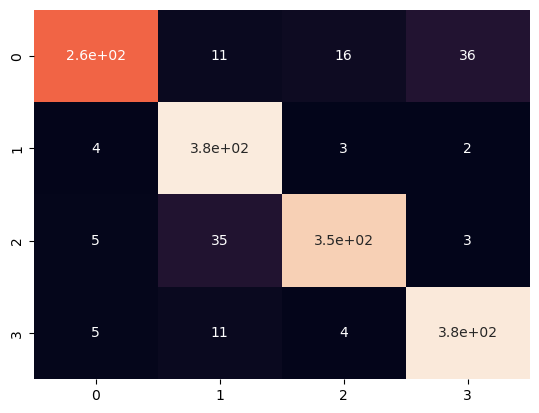

In [35]:
import seaborn as sns 
cm = metrics.confusion_matrix(twenty_test.target, predicted)
sns.heatmap(cm, annot=True, cbar=False)

In [36]:
cm

array([[256,  11,  16,  36],
       [  4, 380,   3,   2],
       [  5,  35, 353,   3],
       [  5,  11,   4, 378]])

In [37]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__ngram_range': [(1,1),(1,2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2,1e-3),
}

In [38]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [39]:
gs_clf = gs_clf.fit(twenty_train.data[:400], twenty_train.target[:400])

In [40]:
twenty_train.target_names[gs_clf.predict(['God is love'])[0]]

'soc.religion.christian'

In [41]:
gs_clf.best_score_

0.9175000000000001

In [42]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [45]:
import pandas as pd

df = pd.DataFrame(gs_clf.cv_results_)

df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_tfidf__use_idf,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.240689,0.033352,0.037914,0.004544,0.01,True,"(1, 1)","{'clf__alpha': 0.01, 'tfidf__use_idf': True, '...",0.9000,0.8625,0.8875,0.9125,0.9000,0.8925,0.016956,4
1,0.667119,0.034486,0.083037,0.008692,0.01,True,"(1, 2)","{'clf__alpha': 0.01, 'tfidf__use_idf': True, '...",0.8875,0.8500,0.9000,0.9250,0.9250,0.8975,0.027839,3
2,0.205208,0.006378,0.037727,0.006057,0.01,False,"(1, 1)","{'clf__alpha': 0.01, 'tfidf__use_idf': False, ...",0.7000,0.7125,0.7750,0.8000,0.8250,0.7625,0.048734,8
3,0.700639,0.024992,0.081571,0.011405,0.01,False,"(1, 2)","{'clf__alpha': 0.01, 'tfidf__use_idf': False, ...",0.6875,0.7000,0.8000,0.8125,0.8375,0.7675,0.061543,7
4,0.204106,0.003438,0.042923,0.010269,0.001,True,"(1, 1)","{'clf__alpha': 0.001, 'tfidf__use_idf': True, ...",0.9000,0.9000,0.9250,0.9250,0.9375,0.9175,0.015000,1
5,0.699441,0.019735,0.082978,0.010231,0.001,True,"(1, 2)","{'clf__alpha': 0.001, 'tfidf__use_idf': True, ...",0.9125,0.8875,0.8875,0.9250,0.9500,0.9125,0.023717,2
6,0.201312,0.009164,0.036410,0.002849,0.001,False,"(1, 1)","{'clf__alpha': 0.001, 'tfidf__use_idf': False,...",0.8250,0.7625,0.7500,0.8000,0.8250,0.7925,0.031225,6
7,0.576888,0.098351,0.064722,0.017297,0.001,False,"(1, 2)","{'clf__alpha': 0.001, 'tfidf__use_idf': False,...",0.8000,0.8000,0.8000,0.8500,0.9000,0.8300,0.040000,5
